In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import GRU, LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
# from numpy import argmax
# from pickle import load
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import load_model
# # from nltk.translate.bleu_score import corpus_bleu
import json
# import random
import csv

from keras.optimizers import SGD
from keras.optimizers import Adam

# SEED = 10
# #IMAGE_EMBEDDING_DIR = '/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/'
# IMAGE_EMBEDDING_DIR = '/content/drive/My Drive/Colab_Notebooks/DL_data/one_sample_cnn/'
# NUM_IMAGE_EMBEDDING_CHUNKS = 1
# GLOVE_EMBEDDING_FILE_NAME = '/content/drive/My Drive/Colab_Notebooks/DL_data/glove.6B.300d.txt'
# MAX_SEQUENCE_LENGTH = 92
# WORD_EMBEDDING_DIM = 300
# CAPTION_FILE_NAME = '/content/drive/My Drive/Colab_Notebooks/DL_data/image_to_caption.csv'
# filepath = '/content/drive/My Drive/Colab_Notebooks/DL_data/model-ep{epoch:03d}-loss{loss:.3f}.h5'


SEED = 10
IMAGE_EMBEDDING_DIR = '/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/'
NUM_IMAGE_EMBEDDING_CHUNKS = 1
GLOVE_EMBEDDING_FILE_NAME = 'glove.6B.300d.txt'
MAX_SEQUENCE_LENGTH = 92
WORD_EMBEDDING_DIM = 300
CAPTION_FILE_NAME = '/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/image_to_caption.csv'

Using TensorFlow backend.
/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/404/404/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/404/404/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/404/404/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)typ

#PreProcess Captions

In [2]:
def getCaptions(id_list):
    caption_dict = {}
    with open(CAPTION_FILE_NAME) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if row[1] in id_list:
                caption_dict[row[1]] = ['startseq ' + row[2] + ' endseq']
                #caption_dict[row[1]] = 'startseq ' + row[2] + ' endseq'
    return caption_dict

In [3]:
def vocab_fun(captions):
  index_to_word = {}
  word_to_index = {}
  all_words = {}
  for img_id, cap in captions.items():
      for c in cap:
          for word in c.split():
            all_words[word] = 1
  all_vocab=[w for w in all_words]
  index = 0
  for word in all_vocab:
      word_to_index[word] = index
      index_to_word[index] = word
      index += 1
  return (all_vocab, word_to_index, index_to_word)

#Preprocess images

In [6]:
def Merge(dict1, dict2): 
    res = {**dict1, **dict2} 
    return res 

def getImageEmbedding(file_name):
    image_embedding = {}
#     for i in range (NUM_IMAGE_EMBEDDING_CHUNKS):
#         file_name = IMAGE_EMBEDDING_DIR + 'group_'+str(i+1)+'.json'
#         with open(file_name) as json_file:
    with open(file_name) as json_file:
#             print(file_name)
            json_data = json.load(json_file)
            json_data = json.loads(json_data)
            image_embedding = Merge(image_embedding, json_data) 
            image_embedding = json_data 
            return image_embedding

In [7]:
# xx = getImageEmbedding()
# yy = {}
# for x in list(reversed(list(xx)))[0:1000]:
#     yy[x] = xx[x]
    
# j = json.dumps(yy)
# with open("json_1000_images", 'w') as outfile:
#     json.dump(j, outfile)

#for fit_generator:

In [8]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch): #descriptions are captions
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split() if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photos[key])
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

#Use Prev to get captions and images and pre_process them

In [9]:
image_embd =  getImageEmbedding()
print(len(image_embd))
# for val in image_embd.values():
#   print(np.shape(val))
#   break
image_ids = list(image_embd.keys())
caption_map = getCaptions(image_ids)
all_vocab, wordtoix, ixtoword=vocab_fun(caption_map)
#tokenizer = create_tokenizer(caption_map)

vocab_size = len(all_vocab)#len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = 94 #max_length(caption_map)
#X1train, X2train, ytrain = create_sequences(tokenizer, max_length, caption_map, image_embd, vocab_size)
#X1test, X2test, ytest = create_sequences(tokenizer, max_length, caption_map, image_embd, vocab_size)

4
Vocabulary Size: 33


#Embedding Matrix

In [10]:
#get matrxi embedding for glove
embeddings_index = {} # empty dictionary
f = open(GLOVE_EMBEDDING_FILE_NAME, encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))
embedding_dim = 300

# Get 300-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


#Building Model

In [11]:
def build_model():
  inputs1 = Input(shape=(2048,),name='images')
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)
  inputs2 = Input(shape=(max_length,),name='sequences')
  se1 = Embedding(vocab_size, WORD_EMBEDDING_DIM, mask_zero=True)(inputs2)
  se2 = Dropout(0.7)(se1)
  se3 = LSTM(256)(se2)
  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  return model

#Training

In [14]:
model=build_model()
model.summary()
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

# optz = SGD(lr=0.1, momentum=0.0, decay=0.1, nesterov=False)
optz = Adam(lr=0.01, decay=0.1)
model.compile(loss='categorical_crossentropy', optimizer=optz)#'adam')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequences (InputLayer)          (None, 94)           0                                            
__________________________________________________________________________________________________
images (InputLayer)             (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 94, 300)      9900        sequences[0][0]                  
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           images[0][0]                     
____________________________________________________________________________________________

In [17]:
batch_size=32
steps = len(caption_map)
epochs = 1
for i in range(epochs):
    generator = data_generator(caption_map, image_embd, wordtoix, max_length, batch_size)
    history = model.fit_generator(generator, epochs=200, steps_per_epoch=steps, verbose=2)
    model.save('late_late_night_model_' + str(i) + '.h5')

Epoch 1/200
 - 12s - loss: 0.0666
Epoch 2/200
 - 11s - loss: 0.0685
Epoch 3/200
 - 12s - loss: 0.0653
Epoch 4/200
 - 9s - loss: 0.0649
Epoch 5/200
 - 6s - loss: 0.0671
Epoch 6/200
 - 6s - loss: 0.0647
Epoch 7/200
 - 7s - loss: 0.0648
Epoch 8/200
 - 8s - loss: 0.0641
Epoch 9/200
 - 7s - loss: 0.0593
Epoch 10/200
 - 7s - loss: 0.0630
Epoch 11/200
 - 7s - loss: 0.0636
Epoch 12/200
 - 10s - loss: 0.0626
Epoch 13/200
 - 11s - loss: 0.0629
Epoch 14/200
 - 10s - loss: 0.0598
Epoch 15/200
 - 11s - loss: 0.0610
Epoch 16/200
 - 11s - loss: 0.0610
Epoch 17/200
 - 12s - loss: 0.0585
Epoch 18/200
 - 11s - loss: 0.0612
Epoch 19/200
 - 13s - loss: 0.0584
Epoch 20/200
 - 11s - loss: 0.0572
Epoch 21/200
 - 10s - loss: 0.0599
Epoch 22/200
 - 12s - loss: 0.0577
Epoch 23/200
 - 11s - loss: 0.0568
Epoch 24/200
 - 12s - loss: 0.0581
Epoch 25/200
 - 19s - loss: 0.0603
Epoch 26/200
 - 20s - loss: 0.0560
Epoch 27/200
 - 12s - loss: 0.0535
Epoch 28/200
 - 12s - loss: 0.0596
Epoch 29/200
 - 15s - loss: 0.0536
Ep

Epoch 34/200
 - 13s - loss: 0.0273
Epoch 35/200
 - 13s - loss: 0.0316
Epoch 36/200
 - 14s - loss: 0.0288
Epoch 37/200
 - 14s - loss: 0.0298
Epoch 38/200
 - 13s - loss: 0.0302
Epoch 39/200
 - 13s - loss: 0.0302
Epoch 40/200
 - 14s - loss: 0.0335
Epoch 41/200
 - 14s - loss: 0.0292
Epoch 42/200
 - 14s - loss: 0.0294
Epoch 43/200
 - 13s - loss: 0.0267
Epoch 44/200
 - 13s - loss: 0.0269
Epoch 45/200
 - 13s - loss: 0.0254
Epoch 46/200
 - 13s - loss: 0.0293
Epoch 47/200
 - 14s - loss: 0.0269
Epoch 48/200
 - 14s - loss: 0.0271
Epoch 49/200
 - 12s - loss: 0.0276
Epoch 50/200
 - 14s - loss: 0.0291
Epoch 51/200
 - 13s - loss: 0.0275
Epoch 52/200
 - 12s - loss: 0.0270
Epoch 53/200
 - 15s - loss: 0.0302
Epoch 54/200
 - 13s - loss: 0.0314
Epoch 55/200
 - 15s - loss: 0.0270
Epoch 56/200
 - 14s - loss: 0.0309
Epoch 57/200
 - 14s - loss: 0.0245
Epoch 58/200
 - 13s - loss: 0.0252
Epoch 59/200
 - 13s - loss: 0.0310
Epoch 60/200
 - 14s - loss: 0.0274
Epoch 61/200
 - 12s - loss: 0.0276
Epoch 62/200
 - 13s 

dict_keys(['loss'])


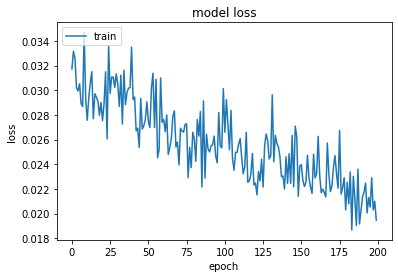

In [18]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [19]:
import os.path as osp
import os
from pprint import pprint
from skimage.transform import rescale, resize
from skimage import data, color, io
import skimage
import PIL
import scipy
import json
import os.path
from os import path
import tensorflow as tf

from keras.applications.xception import preprocess_input
from keras.applications.xception import Xception
from keras.models import Model
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.applications.imagenet_utils import decode_predictions
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def load_image(image_path,target_size):
    img = skimage.io.imread(image_path)
    image_resized = skimage.transform.resize(img, target_size, anti_aliasing=True)
    return image_resized

def load_cnn_model():
    model = Xception()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    return model

def extract_features_from_images(image_path):
    model = load_cnn_model()
    if path.exists(image_path):
        print(image_path)
        image = load_image(image_path, target_size=(299, 299))
        if image.shape == (299, 299, 3):
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
            print(feature)
            return feature

def generate_desc(model, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[word] for word in in_text.split() if word in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        # map integer to word
        word = ixtoword[yhat]
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [20]:
image_path='/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/124919.jpg'#'/Users/vinutahegde/Documents/Personal/IMG_3501.JPG'
feature=extract_features_from_images(image_path)
print(generate_desc(model, feature, max_length))


/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/124919.jpg
[[0.         0.         0.14329363 ... 0.13233422 0.         0.        ]]
startseq we had a very nice day shopping in the city.we each bought a nice tee shirt and had a nice lunch as well . endseq


In [21]:
image_path='/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/124871.jpg'
feature=extract_features_from_images(image_path)
print(generate_desc(model, feature, max_length))

/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/124871.jpg
[[0.         0.         0.16217265 ... 0.11656351 0.         0.        ]]
startseq watching the boats come in endseq


In [23]:
image_path='/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/124885.jpg'
feature=extract_features_from_images(image_path)
print(generate_desc(model, feature, max_length))

/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/124885.jpg
[[0.         0.         0.15100875 ... 0.11124659 0.         0.        ]]
startseq watching the boats come in endseq


In [24]:
image_path='/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/124883.jpg'
feature=extract_features_from_images(image_path)
print(generate_desc(model, feature, max_length))

/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/124883.jpg
[[0.         0.         0.14155498 ... 0.109746   0.         0.        ]]
startseq the bridge had a lot of people on it endseq


In [25]:
image_path='/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/1191943.jpg'
feature=extract_features_from_images(image_path)
print(generate_desc(model, feature, max_length))

/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/1191943.jpg
[[0.         0.         0.15539224 ... 0.12000053 0.         0.        ]]
startseq watching the boats come in endseq


In [26]:
image_path='/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/1144535.jpg'
feature=extract_features_from_images(image_path)
print(generate_desc(model, feature, max_length))

/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/1144535.jpg
[[0.         0.         0.14820762 ... 0.12520814 0.         0.        ]]
startseq we had a very nice day shopping in the city.we each bought a nice tee shirt and had a nice lunch as well . endseq


In [27]:
image_path='/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/1191942.jpg'
feature=extract_features_from_images(image_path)
print(generate_desc(model, feature, max_length))


/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/1191942.jpg
[[0.         0.         0.13261661 ... 0.14653273 0.         0.        ]]
startseq and they were on the shore as well . endseq


In [28]:
print(caption_map['1191942'])

['startseq and they were on the shore as well . endseq']


In [29]:
print(caption_map['1144535'])

['startseq we had a very nice day shopping in the city.we each bought a nice tee shirt and had a nice lunch as well . endseq']


In [31]:
print(caption_map['1191943']) 

['startseq watching the boats come in endseq']
